#Retinopathy Grade Classification using Fastai Library

In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
import pathlib
import copy

Mounted at /content/gdrive


##Preprocessing and Prepairing Data

### splitting data to train/valid/test


As we know, the balance of the data has a significant impact on the interpretation of the results of the evaluation criteria of the model.

Therefore, we observe the ratio of classes in dividing the data into test/train/valid. Actually, in these divisions, we consider the distribution of the classes to be the same.

First of all, use below command to create trainnew.csv :


```
path=pathlib.Path('/....path to data FOLDER..../')
df_aptos=pd.read_csv(path/'train.csv') 
#df_aptos['id_code']=df_aptos['id_code']+'.png'  # for add '.png' in filenames column(i.e. 'id_code')
df_aptos.to_csv('/...path.../trainnew.csv',index=False)
```



In [7]:
#for generating train/valid/test sets

path=pathlib.Path('/content/gdrive/MyDrive/fastai_projects/aptos')
df_aptos=pd.read_csv(path/'trainnew.csv') 
classes=len(df_aptos['diagnosis'].unique())
aptos_test=pd.DataFrame(columns=df_aptos.columns)
aptos_train=pd.DataFrame(columns=df_aptos.columns)
aptos_valid=pd.DataFrame(columns=df_aptos.columns)
aptos_train_valid=pd.DataFrame(columns=['id_code', 'diagnosis','is_valid'])

for i in range(classes):
  classi=df_aptos.loc[df_aptos['diagnosis']==i]
  classi_tst=classi.sample(frac=0.1)
  aptos_test=aptos_test.append(classi_tst)
  classi_res=classi.loc[~classi.index.isin(classi_tst.index)]
  classi_valid=classi_res.sample(frac=2/9)
  aptos_valid=aptos_valid.append(classi_valid)
  classi_train_valid=copy.deepcopy(classi_res)
  classi_train_valid.loc[classi_res.index.isin(classi_valid.index),'is_valid']=True
  classi_train_valid.loc[~classi_res.index.isin(classi_valid.index),'is_valid']=False
  aptos_train_valid=aptos_train_valid.append(classi_train_valid)
  classi_train=classi_res.loc[~classi_res.index.isin(classi_valid.index)]
  aptos_train=aptos_train.append(classi_train)
  print(f'class{i}:','data>',len(classi),',  ','train>',len(classi_train),',  ','valid>',len(classi_valid),',  ','test>',len(classi_tst),',  ','sum>',len(classi_train)+len(classi_valid)+len(classi_tst))

print('df_aptos>',len(df_aptos),',  ','aptos_train>',len(aptos_train),',  ','aptos_valid>',len(aptos_valid),',  ','aptos_test>',len(aptos_test),',  ','sum>',len(aptos_train)+len(aptos_valid)+len(aptos_test))
aptos_train_valid.to_csv('/...path.../aptos_train_valid.csv',index=False)
aptos_test.to_csv('/...path.../aptos_test.csv',index=False)


class0: data> 1805 ,   train> 1264 ,   valid> 361 ,   test> 180 ,   sum> 1805
class1: data> 370 ,   train> 259 ,   valid> 74 ,   test> 37 ,   sum> 370
class2: data> 999 ,   train> 699 ,   valid> 200 ,   test> 100 ,   sum> 999
class3: data> 193 ,   train> 135 ,   valid> 39 ,   test> 19 ,   sum> 193
class4: data> 295 ,   train> 206 ,   valid> 59 ,   test> 30 ,   sum> 295
df_aptos> 3662 ,   aptos_train> 2563 ,   aptos_valid> 733 ,   aptos_test> 366 ,   sum> 3662


### Creating Dataloaders

In [3]:
path=pathlib.Path('/content/gdrive/MyDrive/fastai_projects/aptos')
df_aptos_train=pd.read_csv(path/'aptos_train_valid.csv')  #for training
print(df_aptos_train.shape)
print(df_aptos_train.head())

(3296, 3)
            id_code  diagnosis  is_valid
0  002c21358ce6.png          0     False
1  005b95c28852.png          0     False
2  0097f532ac9f.png          0      True
3  00cc2b75cddd.png          0     False
4  00f6c1be5a33.png          0     False


In [4]:
#%cd path to utils_aptos_classification.py 
%cd /content/gdrive/MyDrive/fastai_projects/aptos

/content/gdrive/MyDrive/fastai_projects/aptos


For system deployment purposes (saving and loading and using the model) we need to put the side codes in another file (please see ‍‍‍`utils_aptos_classification.py`) and import it:

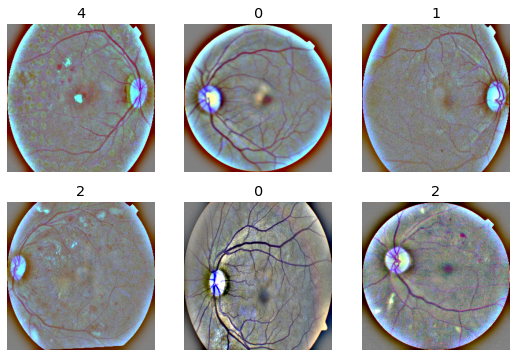

In [5]:
from utils_aptos_classification import get_x_aptos,get_y_aptos
aptos_dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                      get_x=get_x_aptos,
                      get_y=get_y_aptos,
                      batch_tfms=Normalize(),
                      splitter=ColSplitter())
dls_aptos=aptos_dblock.dataloaders(df_aptos_train)
dls_aptos.show_batch(max_n=6)

####creating DataLoaders using **ImageDataLoaders.from_df**

We can also create DataLoders using `ImageDataLoaders.from_df`command:

In [9]:
path=pathlib.Path('/content/gdrive/MyDrive/fastai_projects/aptos')
df_aptos=pd.read_csv(path/'trainnew.csv')
print(df_aptos.shape)
print(df_aptos.head())

(3662, 2)
            id_code  diagnosis
0  000c1434d8d7.png          2
1  001639a390f0.png          4
2  0024cdab0c1e.png          1
3  002c21358ce6.png          0
4  005b95c28852.png          0


In [10]:
dls=ImageDataLoaders.from_df(df_aptos,path,folder='preprocessed',label_col=1,batch_tfms=Normalize(),bs=64)

(#2930) [(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(2)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(2)),(PILImage mode=RGB size=256x256, TensorCategory(3))...] (#732) [(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(1)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(1)),(PILImage mode=RGB size=256x256, TensorCate

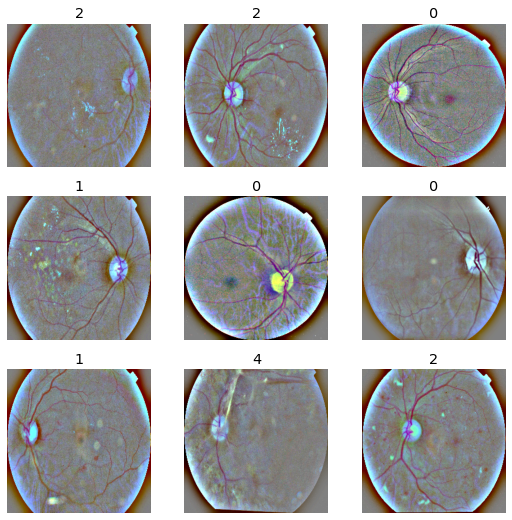

In [12]:
print(dls.train_ds,dls.valid_ds)
dls.train.show_batch()


## Model And Training: Resnet50



In [6]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 37.9 MB/s eta 0:00:00


In [7]:
#%cd path to utils_aptos_classification.py
%cd /content/gdrive/MyDrive/fastai_projects/aptos

/content/gdrive/MyDrive/fastai_projects/aptos


In [8]:
from timm import create_model
from utils_aptos_classification import model_head

net=create_model('resnet50',pretrained=True)
body = create_body(net, pretrained=True, cut=-1)  
head=model_head(2048,5)
model = nn.Sequential(body,head)
apply_init(model[1], nn.init.kaiming_normal_)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [19]:
learn = Learner(dls_aptos, model, loss_func=LabelSmoothingCrossEntropy(),
 #                                splitter=default_split,metrics=accuracy)
                 splitter=default_split,metrics=[accuracy,Precision(average='macro'),
                Recall(average='macro'),F1Score(average='macro'),RocAuc(average='macro')])
learn.freeze()
learn.summary()

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

minimum/10: 5.25e-02, steepest point: 3.02e-03


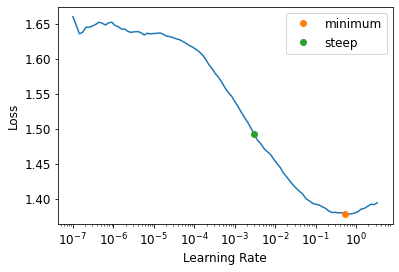

In [ ]:
lr_min,lr_steep=learn.lr_find(suggest_funcs=(minimum,steep))
print(f'minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

In [20]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.143829,1.188484,0.770805,0.529554,0.493035,0.494098,0.828766,00:30
1,1.149263,1.187230,0.772169,0.511902,0.524355,0.513408,0.861506,00:30
2,1.149482,1.183234,0.776262,0.531784,0.509312,0.509494,0.818787,00:31
3,1.146142,1.191858,0.769441,0.519795,0.493174,0.490871,0.796173,00:32
4,1.143791,1.180767,0.777626,0.520899,0.532119,0.522580,0.833269,00:31
5,1.143095,1.180610,0.781719,0.546257,0.514774,0.515822,0.820043,00:31
6,1.139492,1.186366,0.774898,0.540951,0.504907,0.507641,0.821309,00:31
7,1.132249,1.185217,0.777626,0.533126,0.499738,0.500707,0.823080,00:31
8,1.130281,1.186342,0.774898,0.519087,0.503533,0.501614,0.825842,00:31
9,1.130500,1.185059,0.776262,0.520824,0.502143,0.500421,0.823714,00:31


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

In [ ]:
learn.validate()

minimum/10: 7.59e-08, steepest point: 3.98e-04


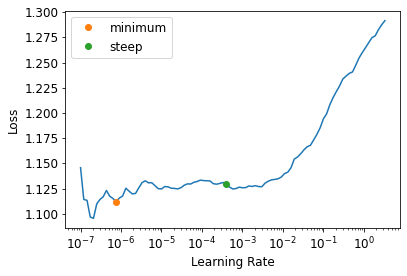

In [21]:
learn.unfreeze()
lr_min,lr_steep=learn.lr_find(suggest_funcs=(minimum,steep))
print(f'minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

In [23]:
learn.fit_one_cycle(30,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.111516,1.180470,0.776262,0.515409,0.521349,0.514890,0.840757,00:38
1,1.111844,1.178009,0.784447,0.523230,0.530308,0.523528,0.840786,00:39
2,1.111864,1.177595,0.783083,0.527709,0.519867,0.516372,0.837785,00:40
3,1.111761,1.177941,0.784447,0.525189,0.534160,0.526209,0.848401,00:40
4,1.113397,1.174028,0.789904,0.533535,0.529646,0.525385,0.834606,00:41
5,1.106324,1.181224,0.774898,0.508540,0.526144,0.515720,0.845550,00:41
6,1.104803,1.174710,0.784447,0.531185,0.523256,0.520290,0.842331,00:41
7,1.103192,1.178267,0.780355,0.516126,0.526739,0.518614,0.844829,00:41
8,1.108493,1.176962,0.783083,0.523696,0.535908,0.527147,0.846765,00:42
9,1.105915,1.177831,0.781719,0.523432,0.526934,0.520971,0.844702,00:42


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

KeyboardInterrupt: ignored

In [ ]:
learn.export('/content/gdrive/MyDrive/fastai_projects/aptos/results/Model And Training: Resnet50_80percent/resnet_aptos_80_with_utils.pkl')

In [ ]:
learn.save('/content/gdrive/MyDrive/fastai_projects/aptos/results/Model And Training: Resnet50_80percent/resnet_aptos_80')

Path('/content/gdrive/MyDrive/fastai_projects/aptos/results/Model And Training: Resnet50_80percent/resnet_aptos_80.pth')

In [ ]:
save_pickle('/content/gdrive/MyDrive/fastai_projects/aptos/results/Model And Training: Resnet50_80percent/resnet_aptos_80_with_utils.pkl',learn)

## test_set

In [ ]:
df_aptos_test=pd.read_csv(path/'aptos_test.csv')
df_aptos_test

,id_code,diagnosis
0,949710bead24.png,0
1,a73c3d516c59.png,0
2,384db24ebbd7.png,0
3,5293576816aa.png,0
4,6f0e5848d9ce.png,0
...,...,...
361,c8d2d32f7f29.png,4
362,8ae049175db6.png,4
363,1e9224ccca95.png,4
364,f03d3c4ce7fb.png,4


In [ ]:
a = test_set(dls_aptos.valid_ds,df_aptos_test); a
print(type(a.tls))
print(a.tls)
print(len(a.tls[0]))
dls_aptos.valid_ds.tls


In [ ]:
dls_aptos.valid_ds,type(dls_aptos.train_ds)

((#733) [(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0))...],
 fastai.data.core.Datasets)

In [ ]:
print(df_aptos.loc[:10])
print(df_aptos.iloc[:10])

In [ ]:
b = test_set(dls_aptos.valid_ds, df_aptos_test, with_labels=True); b

(#366) [(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0)),(PILImage mode=RGB size=256x256, TensorCategory(0))...]

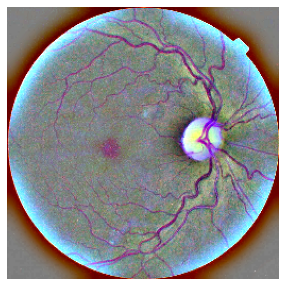

In [ ]:
b[0][0].show()

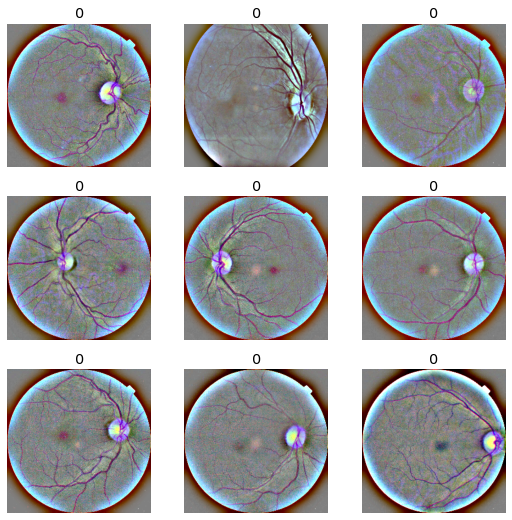

In [ ]:
test_dl=dls_aptos.test_dl(df_aptos_test, with_labels=True)
test_dl.show_batch()

In [ ]:
learn.validate()

(#2) [1.1813552379608154,array([0.96174863, 0.5483871 , 0.61231884, 0.5       , 0.57894737])]

In [ ]:
learn.validate(dl=test_dl)

(#2) [1.1812186241149902,0.7814207673072815]

In [ ]:
preds=learn.get_preds(dl=test_dl)
preds

(tensor([[0.4046, 0.1488, 0.1488, 0.1488, 0.1488],
         [0.4046, 0.1488, 0.1488, 0.1488, 0.1488],
         [0.4046, 0.1488, 0.1488, 0.1488, 0.1488],
         ...,
         [0.1488, 0.1488, 0.4046, 0.1488, 0.1488],
         [0.1488, 0.1488, 0.4046, 0.1488, 0.1488],
         [0.1491, 0.1491, 0.4027, 0.1500, 0.1491]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
type(dls_aptos.train)
type(test_dl.vocab)
type(preds[1])
preds[1].shape

torch.Size([366])

####roc

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(np.array([0,1,2,3,4]))
print(label_binarizer)
y_onehot_test = label_binarizer.transform(preds[1])
y_onehot_test.shape 
print(y_onehot_test)
print(label_binarizer.transform([4]))

LabelBinarizer()
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
[[0 0 0 0 1]]


In [ ]:
class_of_interest = 4
label_binarizer.classes_ == class_of_interest

array([False, False, False, False,  True])

In [ ]:
class_of_interest = 4
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id


((), 4)

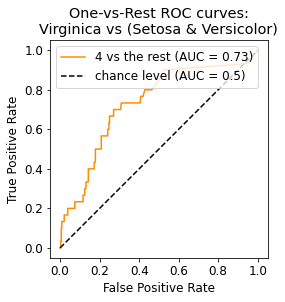

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
y_score=preds[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

##load and predict

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 32.2 MB/s eta 0:00:00


In [ ]:
%cd /content/gdrive/MyDrive/fastai_projects/aptos

/content/gdrive/MyDrive/fastai_projects/aptos


In [ ]:
from utils_aptos_classification import *
mylearn=load_learner('/content/gdrive/MyDrive/fastai_projects/aptos/results/Model And Training: Resnet50_80percent/resnet_aptos_80_with_utils.pkl')
#test_dl=model.dls.test_dl(get_image_files(path)[:100])
#preds=model.get_preds(dl=test_dl)


In [ ]:
mylearn.dls.train_ds
mylearn.validate(dl=test_dl)

(#2) [0.9848332405090332,1.0]

In [ ]:
len(preds),preds[0].shape,preds[1],test_dl

(2, torch.Size([100, 5]), None, <fastai.data.core.TfmdDL at 0x7f5886847940>)